# Experiment with complete Lagrangian from exponentiated gradient as grid for grid search

In this, we compare time, violation and error from expgrad on full dataset, gridsearch on full dataset, hybrid model with various fractions of subsets.

### Notes:

1. For hybrid model, we report 2 values - expgrad on partial dataset and grid search by re-training all classifiers with output lagrangian of expgrad.

2. As predict may give variable results (due to randomisation), `_pmf_predict` is used to get the value of the `y_pred` for exp grad (in both cases - on partial and also on full dataset).

3. [Not used] Normalised values are calculated by: `({value}-{eps}) / {eps}` for violation and `({value}-{expgrad on full dataset})/{expgrad on full dataset}` for error.


In [1]:
!pip install fairlearn

     |████████████████████████████████| 21.2MB 1.5MB/s 


In [2]:
!pip install tempeh

     |████████████████████████████████| 276kB 13.7MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.57.0-cp36-none-any.whl size=28992 sha256=621376f12faaf6ef4938127fe5a1e5a2ddb83162f63837508db1fb5a831044bf
  Stored in directory: /root/.cache/pip/wheels/74/20/b5/20964ef97be73d2c3a695c9cad7bccd96d1e3e737a8163861f
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394120 sha256=ece9b67148ba19f058bb084aaf6b1e1b72b676e2b4477e061bfd97cd349db490
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built memory-profiler shap


In [3]:
# load data
import numpy as np
import pandas as pd
from datetime import datetime 
from IPython.display import display, HTML
import statistics 
import scipy.stats as st
from fairlearn.reductions import ExponentiatedGradient
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tempeh.configurations import datasets

compas_dataset = datasets['compas']()
X_train_all, X_test = compas_dataset.get_X(format=pd.DataFrame)
y_train_all, y_test = compas_dataset.get_y(format=pd.Series)
A_train_all, A_test = compas_dataset.get_sensitive_features('race', format=pd.Series)

train_all = pd.concat([X_train_all, y_train_all, A_train_all], axis=1)

In [4]:
# Subsampling process
num_samples = 20
fractions = np.logspace(-2, 0, num=20)
eps = 0.05

In [5]:
#Unmitigated LogRes
from sklearn.linear_model import LogisticRegression
logistic_learner = LogisticRegression(solver='liblinear', fit_intercept=True)
logistic_learner.fit(X_train_all, y_train_all)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [6]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, DemographicParity, ErrorRate
import numpy as np

In [7]:
# Error & Violation of unmitigated estimator
def UnmitLogistic(X): return logistic_learner.predict(X)
# violation
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all,
                           sensitive_features=A_train_all)
log_violation_unmitigated = disparity_moment.gamma(UnmitLogistic).max()

# error
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
log_error_unmitigated = error.gamma(UnmitLogistic)[0]
print('Logistic Regression - Violation: {}, Error: {}'.format(
    log_violation_unmitigated, log_error_unmitigated))

Logistic Regression - Violation: 0.15129907254478464, Error: 0.33455882352941174


In [8]:
# Expgrad on full dataset
expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(), eps=eps, nu=1e-6)

a=datetime.now()
expgrad_X_logistic.fit(X_train_all, y_train_all,
                       sensitive_features=A_train_all)
b=datetime.now()
time_expgrad_all = (b-a).seconds

def Qexp_all(X): return expgrad_X_logistic._pmf_predict(X)[:, 1]
# violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all,
                           sensitive_features=A_train_all)
violation_expgrad_all = disparity_moment.gamma(Qexp_all).max()

# error of log res
error = ErrorRate()
error.load_data(X_train_all, y_train_all,
                sensitive_features=A_train_all)
error_expgrad_all = error.gamma(Qexp_all)[0]

print('Exponentiated gradient on full dataset : Time: {} seconds; Violation: {}; Errror: {}'.format(
    time_expgrad_all, violation_expgrad_all, error_expgrad_all))

Exponentiated gradient on full dataset : Time: 7 seconds; Violation: 0.05000000000000043; Errror: 0.391800773607157


## Experiment 1: Hybrid 1

### Notes:

1. For grid search in hybrid model, we get `y_pred` using the best classifier out of all the predictors.

In [9]:
def _pmf_predict(X, predictors, weights):
    pred = pd.DataFrame()
    for t in range(len(predictors)):
        pred[t] = predictors[t].predict(X)
    positive_probs = pred[weights.index].dot(weights).to_frame()
    return np.concatenate((1-positive_probs, positive_probs), axis=1)

In [10]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import logging
import numpy as np
import pandas as pd
import pickle
import scipy.optimize as opt
from sklearn.dummy import DummyClassifier
from time import time

_PRECISION = 1e-8
_LINE = "_" * 9
_INDENTATION = " " * 9

logger = logging.getLogger(__name__)


class _Lagrangian:
    """Operations related to the Lagrangian.

    :param X: the training features
    :type X: Array
    :param sensitive_features: the sensitive features to use for constraints
    :type sensitive_features: Array
    :param y: the training labels
    :type y: Array
    :param estimator: the estimator to fit in every iteration of best_h
    :type estimator: an estimator that has a `fit` method with arguments X, y, and sample_weight
    :param constraints: Object describing the parity constraints. This provides the reweighting
        and relabelling
    :type constraints: `fairlearn.reductions.Moment`
    :param eps: allowed constraint violation
    :type eps: float
    :param B:
    :type B:
    :param opt_lambda: indicates whether to optimize lambda during the calculation of the
        Lagrangian; optional with default value True
    :type opt_lambda: bool
    """

    def __init__(self, X, sensitive_features, y, estimator, constraints, eps, B, opt_lambda=True):
        self.X = X
        self.constraints = constraints
        self.constraints.load_data(X, y, sensitive_features=sensitive_features)
        self.obj = self.constraints.default_objective()
        self.obj.load_data(X, y, sensitive_features=sensitive_features)
        self.pickled_estimator = pickle.dumps(estimator)
        self.eps = eps
        self.B = B
        self.opt_lambda = opt_lambda
        self.hs = pd.Series(dtype="float64")
        self.classifiers = pd.Series(dtype="float64")
        self.errors = pd.Series(dtype="float64")
        self.gammas = pd.DataFrame()
        self.lambdas = pd.DataFrame()
        self.n = self.X.shape[0]
        self.n_oracle_calls = 0
        self.n_oracle_calls_dummy_returned = 0
        self.oracle_execution_times = []
        self.last_linprog_n_hs = 0
        self.last_linprog_result = None

    def _eval(self, Q, lambda_vec):
        """Return the value of the Lagrangian.

        :param Q: `Q` is either a series of weights summing up to 1 that indicate the weight of
            each `h` in contributing to the randomized classifier, or a callable corresponding to
            a deterministic predict function.
        :type Q: pandas.Series or callable
        :param lambda_vec: lambda vector
        :type lambda_vec: pandas.Series

        :return: tuple `(L, L_high, gamma, error)` where `L` is the value of the Lagrangian,
            `L_high` is the value of the Lagrangian under the best response of the lambda player,
            `gamma` is the vector of constraint violations, and `error` is the empirical error
        """
        if callable(Q):
            error = self.obj.gamma(Q)[0]
            gamma = self.constraints.gamma(Q)
        else:
            error = self.errors[Q.index].dot(Q)
            gamma = self.gammas[Q.index].dot(Q)

        if self.opt_lambda:
            lambda_projected = self.constraints.project_lambda(lambda_vec)
            L = error + np.sum(lambda_projected * gamma) - self.eps * np.sum(lambda_projected)
        else:
            L = error + np.sum(lambda_vec * gamma) - self.eps * np.sum(lambda_vec)

        max_gamma = gamma.max()
        if max_gamma < self.eps:
            L_high = error
        else:
            L_high = error + self.B * (max_gamma - self.eps)
        return L, L_high, gamma, error

    def eval_gap(self, Q, lambda_hat, nu):
        r"""Return the duality gap object for the given :math:`Q` and :math:`\hat{\lambda}`."""
        L, L_high, gamma, error = self._eval(Q, lambda_hat)
        result = _GapResult(L, L, L_high, gamma, error)
        for mul in [1.0, 2.0, 5.0, 10.0]:
            h_hat, h_hat_idx = self.best_h(mul * lambda_hat)
            logger.debug("%smul=%.0f", _INDENTATION, mul)
            L_low_mul, _, _, _ = self._eval(pd.Series({h_hat_idx: 1.0}), lambda_hat)
            if L_low_mul < result.L_low:
                result.L_low = L_low_mul
            if result.gap() > nu + _PRECISION:
                break
        return result

    def solve_linprog(self, errors=None, gammas=None, nu=1e-6):
        if errors is None:
          errors = self.errors
        if gammas is None:
          gammas = self.gammas
        n_hs = len(self.hs)
        n_constraints = len(self.constraints.index)
        if self.last_linprog_n_hs == n_hs:
            return self.last_linprog_result
        c = np.concatenate((errors, [self.B]))
        A_ub = np.concatenate((gammas - self.eps, -np.ones((n_constraints, 1))), axis=1)
        b_ub = np.zeros(n_constraints)
        A_eq = np.concatenate((np.ones((1, n_hs)), np.zeros((1, 1))), axis=1)
        b_eq = np.ones(1)
        result = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, method='simplex')
        Q = pd.Series(result.x[:-1], self.hs.index)
        dual_c = np.concatenate((b_ub, -b_eq))
        dual_A_ub = np.concatenate((-A_ub.transpose(), A_eq.transpose()), axis=1)
        dual_b_ub = c
        dual_bounds = [(None, None) if i == n_constraints else (0, None) for i in range(n_constraints + 1)]  # noqa: E501
        result_dual = opt.linprog(dual_c,
                                  A_ub=dual_A_ub,
                                  b_ub=dual_b_ub,
                                  bounds=dual_bounds,
                                  method='simplex')
        lambda_vec = pd.Series(result_dual.x[:-1], self.constraints.index)
        self.last_linprog_n_hs = n_hs
        self.last_linprog_result = (Q, lambda_vec, self.eval_gap(Q, lambda_vec, nu))
        return self.last_linprog_result

    def _call_oracle(self, lambda_vec):
        signed_weights = self.obj.signed_weights() + self.constraints.signed_weights(lambda_vec)
        redY = 1 * (signed_weights > 0)
        redW = signed_weights.abs()
        redW = self.n * redW / redW.sum()

        redY_unique = np.unique(redY)

        classifier = None
        if len(redY_unique) == 1:
            logger.debug("redY had single value. Using DummyClassifier")
            classifier = DummyClassifier(strategy='constant',
                                         constant=redY_unique[0])
            self.n_oracle_calls_dummy_returned += 1
        else:
            classifier = pickle.loads(self.pickled_estimator)

        oracle_call_start_time = time()
        classifier.fit(self.X, redY, sample_weight=redW)
        self.oracle_execution_times.append(time() - oracle_call_start_time)
        self.n_oracle_calls += 1

        return classifier

    def best_h(self, lambda_vec):
        """Solve the best-response problem.

        Returns the classifier that solves the best-response problem for
        the vector of Lagrange multipliers `lambda_vec`.
        """
        classifier = self._call_oracle(lambda_vec)
        def h(X): return classifier.predict(X)
        h_error = self.obj.gamma(h)[0]
        h_gamma = self.constraints.gamma(h)
        h_value = h_error + h_gamma.dot(lambda_vec)

        if not self.hs.empty:
            values = self.errors + self.gammas.transpose().dot(lambda_vec)
            best_idx = values.idxmin()
            best_value = values[best_idx]
        else:
            best_idx = -1
            best_value = np.PINF

        if h_value < best_value - _PRECISION:
            logger.debug("%sbest_h: val improvement %f", _LINE, best_value - h_value)
            h_idx = len(self.hs)
            self.hs.at[h_idx] = h
            self.classifiers.at[h_idx] = classifier
            self.errors.at[h_idx] = h_error
            self.gammas[h_idx] = h_gamma
            self.lambdas[h_idx] = lambda_vec.copy()
            best_idx = h_idx

        return self.hs[best_idx], best_idx


class _GapResult:
    """The result of a duality gap computation."""

    def __init__(self, L, L_low, L_high, gamma, error):
        self.L = L
        self.L_low = L_low
        self.L_high = L_high
        self.gamma = gamma
        self.error = error

    def gap(self):
        return max(self.L - self.L_low, self.L_high - self.L)


In [11]:
def solve_linprog(errors=None, gammas=None, eps=0.05, nu=1e-6, pred=None):
    B = 1/eps
    n_hs = len(pred)
    n_constraints = 4 #len()

    c = np.concatenate((errors, [B]))
    A_ub = np.concatenate((gammas - eps, -np.ones((n_constraints, 1))), axis=1)
    b_ub = np.zeros(n_constraints)
    A_eq = np.concatenate((np.ones((1, n_hs)), np.zeros((1, 1))), axis=1)
    b_eq = np.ones(1)
    result = opt.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, method='simplex')
    Q = pd.Series(result.x[:-1])
    return Q

def eval_(error, gamma, lambda_vec, eps):
    return error + np.sum(lambda_vec * gamma) - eps * np.sum(lambda_vec)

In [12]:
# hybrid model

# Variables
error_expgrad_fracs = []
error_expgrad_alls = []

error_rewt_partial1 = [] # k=2 or len(pred) whatever is smaller
error_rewt_partial2 = [] # k=4 or len(pred) whatever is smaller
error_rewt_partial3 = [] # k=6 or len(pred) whatever is smaller
error_rewt_partial4 = [] # k=8 or len(pred) whatever is smaller
error_rewt_partial5 = [] # k=10 or len(pred) whatever is smaller

error_rewt_all = [] # k=len(pred)
error_rewt_partial = [] # non-zero


vio_expgrad_fracs = []
vio_expgrad_alls = []

vio_rewt_partial1 = [] # k=2 or len(pred) whatever is smaller
vio_rewt_partial2 = [] # k=4 or len(pred) whatever is smaller
vio_rewt_partial3 = [] # k=6 or len(pred) whatever is smaller
vio_rewt_partial4 = [] # k=8 or len(pred) whatever is smaller
vio_rewt_partial5 = [] # k=10 or len(pred) whatever is smaller

vio_rewt_all = [] # k=len(pred)
vio_rewt_partial = [] # non-zero

k_list = [2,4,6,8,10]
B = 1 / eps

# Iterations on difference fractions
for i,f in enumerate(fractions):
    error_expgrad_alls.append(error_expgrad_all)
    vio_expgrad_alls.append(violation_expgrad_all)
    

    _error_expgrad_fracs = []

    _error_rewt_partial1 = [] # k=2 or len(pred) whatever is smaller
    _error_rewt_partial2 = [] # k=4 or len(pred) whatever is smaller
    _error_rewt_partial3 = [] # k=6 or len(pred) whatever is smaller
    _error_rewt_partial4 = [] # k=8 or len(pred) whatever is smaller
    _error_rewt_partial5 = [] # k=10 or len(pred) whatever is smaller

    _error_rewt_all = [] # k=len(pred)
    _error_rewt_partial = [] # non-zero


    _vio_expgrad_fracs = []

    _vio_rewt_partial1 = [] # k=2 or len(pred) whatever is smaller
    _vio_rewt_partial2 = [] # k=4 or len(pred) whatever is smaller
    _vio_rewt_partial3 = [] # k=6 or len(pred) whatever is smaller
    _vio_rewt_partial4 = [] # k=8 or len(pred) whatever is smaller
    _vio_rewt_partial5 = [] # k=10 or len(pred) whatever is smaller

    _vio_rewt_all = [] # k=len(pred)
    _vio_rewt_partial = [] # non-zero


    print("\nFraction: ", f)

    for n in range(num_samples):
        # get samples
        subsampling = train_all.sample(frac=f, random_state=n+20)
        subsampling = subsampling.reset_index()
        subsampling = subsampling.drop(columns=['index'])
        tmp = subsampling.iloc[:, :-1]
        A_train = subsampling.iloc[:, -1]
        X_train = tmp.iloc[:, :-1]
        y_train = tmp.iloc[:,-1]

        # Expgrad on sub dataset
        expgrad_X_logistic_frac = ExponentiatedGradient(
            LogisticRegression(solver='liblinear', fit_intercept=True),
            constraints=DemographicParity(), eps=eps, nu=1e-6)
        expgrad_X_logistic_frac.fit(X_train, y_train, sensitive_features=A_train)
        
        def Qexp(X): return expgrad_X_logistic_frac._pmf_predict(X)[:, 1]
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all,
                                   sensitive_features=A_train_all)
        violation_expgrad_logistic_frac = disparity_moment.gamma(Qexp).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all,
                        sensitive_features=A_train_all)
        error_expgrad_logistic_frac = error.gamma(Qexp)[0]

        _error_expgrad_fracs.append(error_expgrad_logistic_frac)
        _vio_expgrad_fracs.append(violation_expgrad_logistic_frac)

        print(len(expgrad_X_logistic_frac._predictors), end =", ")
        _weights_logistic = expgrad_X_logistic_frac._weights
        # fixing lambda
        lambda_vecs = expgrad_X_logistic_frac._lambda_vecs
        lambda_vec = lambda_vecs[lambda_vecs.columns[len(lambda_vecs.columns)-1]]
        
        # Grid Search part
        lambda_vecs_logistic = expgrad_X_logistic_frac._lambda_vecs_lagrangian
        grid_search_logistic_frac = GridSearch(
            LogisticRegression(solver='liblinear', fit_intercept=True),
            constraints=DemographicParity(), grid=lambda_vecs_logistic)
        grid_search_logistic_frac.fit(X_train_all, y_train_all,
                                      sensitive_features=A_train_all)

        _predictors = grid_search_logistic_frac._predictors

        # Hybrid: re-weight using LP
        # Sort pred based on lagrangian (we minimise over Q) - so, ascending order sort
        grid_errors = []
        grid_vio = pd.DataFrame()
        lagrangian = []
        # Get error/vio for all predictors
        for x in range(len(_predictors)):
          def Q_preds(X): return _predictors[x].predict(X)
          # violation of log res
          disparity_moment = DemographicParity()
          disparity_moment.load_data(X_train_all, y_train_all,
                                    sensitive_features=A_train_all)
          violation_grid_frac = disparity_moment.gamma(Q_preds)

          # error of log res
          error = ErrorRate()
          error.load_data(X_train_all, y_train_all,
                          sensitive_features=A_train_all)
          error_grid_frac = error.gamma(Q_preds)['all']

          grid_vio[x] = violation_grid_frac
          grid_errors.append(error_grid_frac)
        grid_errors = pd.Series(grid_errors)

        for x in range(len(_predictors)):
          lagrangian.append(eval_(grid_errors[x], grid_vio[x], lambda_vec, eps))

        sorted_index = np.argsort(lagrangian)
        for k in k_list:
          fin_pred = []
          fin_gamma = pd.DataFrame()
          fin_error = []
          for element in range(k):
            if element >= len(_predictors):
              fin_pred.append(_predictors[sorted_index[-1]])
              fin_gamma[element] = grid_vio[sorted_index[-1]]
              fin_error.append(grid_errors[sorted_index[-1]])
            else:
              fin_pred.append(_predictors[sorted_index[element]])
              fin_gamma[element] = grid_vio[sorted_index[element]]
              fin_error.append(grid_errors[sorted_index[element]])
          #fin_gamma = pd.Series(fin_gamma)
          fin_error = pd.Series(fin_error)
          new_weights = solve_linprog(errors=fin_error, gammas=fin_gamma, eps=0.05, nu=1e-6, pred=fin_pred)
          def Q_rewts(X): return _pmf_predict(X, fin_pred, new_weights)[:,1]
          # violation of log res
          disparity_moment = DemographicParity()
          disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
          vio_rewts_pmf_ = disparity_moment.gamma(Q_rewts).max()

          # error of log res
          error = ErrorRate()
          error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
          error_rewts_pmf_ = error.gamma(Q_rewts)[0]

          if k == 2:
            _error_rewt_partial1.append(error_rewts_pmf_) # k=2 or len(pred) whatever is smaller
            _vio_rewt_partial1.append(vio_rewts_pmf_) # k=2 or len(pred) whatever is smaller
          elif k == 4:
            _error_rewt_partial2.append(error_rewts_pmf_) # k=4 or len(pred) whatever is smaller
            _vio_rewt_partial2.append(vio_rewts_pmf_) # k=4 or len(pred) whatever is smaller
          elif k == 6:
            _error_rewt_partial3.append(error_rewts_pmf_) # k=6 or len(pred) whatever is smaller
            _vio_rewt_partial3.append(vio_rewts_pmf_) # k=6 or len(pred) whatever is smaller
          elif k == 8:
            _error_rewt_partial4.append(error_rewts_pmf_) # k=8 or len(pred) whatever is smaller
            _vio_rewt_partial4.append(vio_rewts_pmf_) # k=8 or len(pred) whatever is smaller
          elif k == 10:
            _error_rewt_partial5.append(error_rewts_pmf_) # k=10 or len(pred) whatever is smaller
            _vio_rewt_partial5.append(vio_rewts_pmf_) # k=10 or len(pred) whatever is smaller

        # for all preds
        new_weights = solve_linprog(errors=grid_errors, gammas=grid_vio, eps=0.05, nu=1e-6, pred=_predictors)
        def Q_rewts(X): return _pmf_predict(X, _predictors, new_weights)[:,1]
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        vio_rewts_pmf_ = disparity_moment.gamma(Q_rewts).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        error_rewts_pmf_ = error.gamma(Q_rewts)[0]

        _error_rewt_all.append(error_rewts_pmf_) # k=len(pred)
        _vio_rewt_all.append(vio_rewts_pmf_)


        # Hybrid: re-weight only the non-zero weight predictors using LP
        re_wts_predictors = []
        for x in  range(len(_weights_logistic)):
          if _weights_logistic[x] != 0:
            re_wts_predictors.append(_predictors[x])
        grid_errors_partial = []
        grid_vio_partial = pd.DataFrame()
        for x in range(len(re_wts_predictors)):
          def Q_preds_partial(X): return re_wts_predictors[x].predict(X)
          # violation of log res
          disparity_moment = DemographicParity()
          disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
          violation_grid_frac_partial = disparity_moment.gamma(Q_preds_partial)

          # error of log res
          error = ErrorRate()
          error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
          error_grid_frac_partial = error.gamma(Q_preds_partial)['all']

          grid_vio_partial[x] = violation_grid_frac_partial
          grid_errors_partial.append(error_grid_frac_partial)

        grid_errors_partial = pd.Series(grid_errors_partial)
        new_weights_partial = solve_linprog(errors=grid_errors_partial, gammas=grid_vio_partial, eps=0.05, nu=1e-6, pred=re_wts_predictors)
        def Q_rewts_partial(X): return _pmf_predict(X, re_wts_predictors, new_weights_partial)[:,1]
        # violation of log res
        disparity_moment = DemographicParity()
        disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        vio_rewts_partial_ = disparity_moment.gamma(Q_rewts_partial).max()

        # error of log res
        error = ErrorRate()
        error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
        error_rewts_partial_ = error.gamma(Q_rewts_partial)[0]

        _vio_rewt_partial.append(vio_rewts_partial_)
        _error_rewt_partial.append(error_rewts_partial_)

    error_expgrad_fracs.append(np.mean(_error_expgrad_fracs))
    vio_expgrad_fracs.append(np.mean(_vio_expgrad_fracs))

    # Hybrid: re-weight using LP
    error_rewt_partial1.append(np.mean(_error_rewt_partial1)) # k=2 or len(pred) whatever is smaller
    vio_rewt_partial1.append(np.mean(_vio_rewt_partial1)) # k=2 or len(pred) whatever is smaller
  
    error_rewt_partial2.append(np.mean(_error_rewt_partial2)) # k=4 or len(pred) whatever is smaller
    vio_rewt_partial2.append(np.mean(_vio_rewt_partial2)) # k=4 or len(pred) whatever is smaller
  
    error_rewt_partial3.append(np.mean(_error_rewt_partial3)) # k=6 or len(pred) whatever is smaller
    vio_rewt_partial3.append(np.mean(_vio_rewt_partial3)) # k=6 or len(pred) whatever is smaller

    error_rewt_partial4.append(np.mean(_error_rewt_partial4)) # k=8 or len(pred) whatever is smaller
    vio_rewt_partial4.append(np.mean(_vio_rewt_partial4)) # k=8 or len(pred) whatever is smaller

    error_rewt_partial5.append(np.mean(_error_rewt_partial5)) # k=10 or len(pred) whatever is smaller
    vio_rewt_partial5.append(np.mean(_vio_rewt_partial5)) # k=10 or len(pred) whatever is smaller

    vio_rewt_partial.append(np.mean(_vio_rewt_partial))
    error_rewt_partial.append(np.mean(_error_rewt_partial))
    
    vio_rewt_all.append(np.mean(_vio_rewt_all))
    error_rewt_all.append(np.mean(_error_rewt_all))



Fraction:  0.01
6, 4, 4, 7, 10, 6, 2, 1, 5, 4, 6, 4, 1, 5, 8, 3, 5, 5, 4, 2, 
Fraction:  0.012742749857031334
3, 1, 6, 2, 5, 4, 2, 2, 5, 5, 2, 3, 1, 6, 3, 4, 4, 6, 5, 2, 
Fraction:  0.016237767391887217
3, 3, 3, 3, 4, 3, 3, 1, 3, 5, 4, 4, 1, 7, 6, 3, 1, 7, 1, 3, 
Fraction:  0.0206913808111479
5, 5, 5, 2, 5, 3, 3, 3, 4, 5, 3, 5, 7, 8, 2, 5, 7, 5, 1, 4, 
Fraction:  0.026366508987303583
7, 5, 10, 4, 6, 6, 6, 6, 5, 5, 2, 4, 6, 10, 9, 8, 7, 6, 2, 4, 
Fraction:  0.03359818286283781
6, 8, 10, 6, 6, 2, 5, 4, 8, 5, 5, 5, 8, 9, 9, 7, 9, 8, 6, 5, 
Fraction:  0.04281332398719394
10, 3, 8, 10, 5, 6, 4, 6, 7, 7, 5, 8, 10, 8, 7, 5, 8, 9, 8, 9, 
Fraction:  0.0545559478116852
7, 5, 7, 4, 5, 6, 3, 4, 10, 6, 5, 5, 9, 11, 9, 5, 7, 9, 5, 5, 
Fraction:  0.06951927961775606
7, 8, 11, 5, 8, 8, 6, 7, 9, 4, 7, 5, 5, 4, 10, 4, 8, 8, 4, 5, 
Fraction:  0.08858667904100823
7, 7, 11, 3, 11, 11, 5, 6, 10, 4, 7, 8, 4, 6, 6, 7, 5, 9, 5, 9, 
Fraction:  0.11288378916846889
11, 7, 9, 5, 8, 7, 7, 8, 9, 8, 9, 6, 7, 5, 10, 

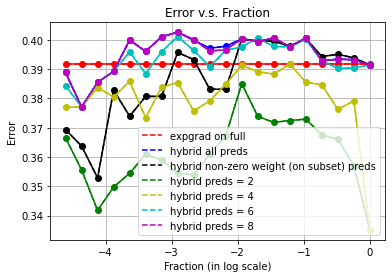

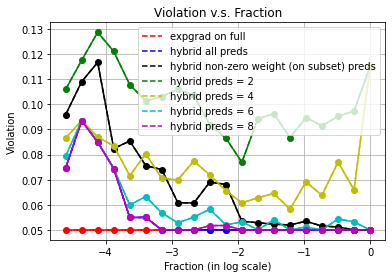

In [13]:
import matplotlib.pyplot as plt
fr = np.log(fractions) 
l1 = plt.plot(fr, error_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fr, error_rewt_all,'b--',label="hybrid all preds")
l3 = plt.plot(fr, error_rewt_partial,'k--',label="hybrid non-zero weight (on subset) preds")

l4 = plt.plot(fr, error_rewt_partial1,'g--',label="hybrid preds = 2")
l5 = plt.plot(fr, error_rewt_partial2, 'y--',label="hybrid preds = 4")
l6 = plt.plot(fr, error_rewt_partial3,'c--',label="hybrid preds = 6")
l7 = plt.plot(fr, error_rewt_partial4,'m--',label="hybrid preds = 8")


plt.plot(fr, error_expgrad_alls,'ro-',
         fr, error_rewt_all,'bo-',
         fr, error_rewt_partial,'ko-',
         fr, error_rewt_partial1, 'go-',
         fr, error_rewt_partial2,'yo-',
         fr, error_rewt_partial3,'co-',
         fr, error_rewt_partial4,'mo-',
         )
plt.xlabel('Fraction (in log scale)')
plt.ylabel('Error')
plt.title('Error v.s. Fraction')
plt.grid()
plt.legend()
plt.show()


l1 = plt.plot(fr, vio_expgrad_alls,'r--',label="expgrad on full")
l2 = plt.plot(fr, vio_rewt_all,'b--',label="hybrid all preds")
l3 = plt.plot(fr, vio_rewt_partial,'k--',label="hybrid non-zero weight (on subset) preds")

l4 = plt.plot(fr, vio_rewt_partial1,'g--',label="hybrid preds = 2")
l5 = plt.plot(fr, vio_rewt_partial2, 'y--',label="hybrid preds = 4")
l6 = plt.plot(fr, vio_rewt_partial3,'c--',label="hybrid preds = 6")
l7 = plt.plot(fr, vio_rewt_partial4,'m--',label="hybrid preds = 8")


plt.plot(fr, vio_expgrad_alls,'ro-',
         fr, vio_rewt_all,'bo-',
         fr, vio_rewt_partial,'ko-',
         fr, vio_rewt_partial1, 'go-',
         fr, vio_rewt_partial2,'yo-',
         fr, vio_rewt_partial3,'co-',
         fr, vio_rewt_partial4,'mo-',
         )
plt.xlabel('Fraction (in log scale)')
plt.ylabel('Violation')
plt.title('Violation v.s. Fraction')
plt.grid()
plt.legend()
plt.show()